# IOOS models

This is the first post on the series "IOOS Ocean Models IOOS."


The IOOS regional associations produces terabytes (petabytes?) of numeric ocean models results.
They can be easily found via the catalog, but reading the data is not always trivial.
Thanks to standardized metadata and grid specs one read the data and compare different models results.

The first post on this series will deal with model grids.
We have many different grid types that conform to known standards,
like UGRID and SGRID,
and some that may fall into one of those categories but do not have sufficient metadata to be easily identified.

In order to be able to extract them without worrying about the underlying nature of the grids we will use `gridgeo`.
`gridgeo` abstracts out the grid parsing to the known standards,
and do some heuristics on non-compliant data,
to extract a [`GeoJSON`](http://geojson.org/) representation of the grid.

Here is the list of models we will work in this notebook:

In [1]:
models = {
    'CNAPS':
    {
        'url': 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
    'NECOFS':
    {
        'url': 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
    'ESPRESSO':
    {
        'url': 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
#     FIXME: returning 500 error at the moment.
#     'WCOFS':
#     {
#         'url': 'http://data.oceansmap.com/thredds/dodsC/EDS/WCOFS',
#         'var': {'long_name': 'model surface potential temperature'},
#     },
    'OSU_ROMS':
    {
        'url': 'http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS',
        'var': {'standard_name': 'sea_water_potential_temperature'}
    },
    'NYHOPS':
    {
        'url': 'http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc',
        'var': {'standard_name': 'sea_water_temperature'},
    },
    'Columbia River':
    {
        'url': 'http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast.nc',
        'var': {'standard_name': 'sea_surface_temperature'},
    },
    'WestCoastUCSC':
    {
        'url': 'http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd',
        'var': {'long_name': 'potential temperature'},
    },
}

Some models may have different grids for the different variables.
According to the Climate and Forecast standards we need to check the grid for a phenomena (variable).

Below we loop over the models, load the `netCDF4-python` object,
and feed it to `GridGeo` checking the variable associated with temperature.

In [2]:
from gridgeo import GridGeo
from netCDF4 import Dataset


for model, value in models.items():
    try:
        nc = Dataset(value['url'])
    except Exception:
        print(f'Could not download {value["url"]}')
        continue
    models[model].update({'nc': nc})
    models[model].update({'grid': GridGeo(nc, **value['var'])})

The cell below is a bit boring (and probably unnecessarily complex).
However, we need those functions to extract grid statistics and to easily plot them.

In [3]:
%matplotlib inline

import cartopy.crs as ccrs
from cartopy.feature import COLORS, NaturalEarthFeature

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import numpy as np

from pandas import DataFrame


LAND = NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor=COLORS['land']
)

def plot_grid(grid, color='darkgray'):
    polygon = PolyCollection(
        grid.polygons,
        alpha=0.2,
        facecolor='none',
        edgecolor='gray',
        transform=ccrs.Geodetic(),
    )

    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={'projection': ccrs.PlateCarree()},
    )
    ax.add_feature(LAND, zorder=0, edgecolor='black')
    ax.set_title(grid.mesh)

    if grid.mesh in ['unknown_1d', 'unknown_2d', 'sgrid']:
        if grid.mesh == 'unknown_1d':
            x, y = np.meshgrid(grid.x, grid.y)
        ax.plot(
            grid.x, grid.y, color,
            grid.x.T, grid.y.T, color,
            alpha=0.25,
        )
    elif grid.mesh == 'ugrid':
        kw = dict(linestyle='-', alpha=0.25, color=color)
        ax.triplot(grid.triang, **kw)
    else:
        raise ValueError(f'Unrecognized grid type {grid.mesh}.')
        

    return fig, ax


def cftime(time):
    from netCDF4 import num2date
    times = time[:]
    calendar = getattr(time, 'calendar', 'standard')
    return num2date(times[0:2], time.units, calendar=calendar)


def _vlevel(var):
    try:
        vlevel = var.z_axis().shape[0]
    except ValueError:
        vlevel = None
    return vlevel


def _tstep(var):
    try:
        tstep = np.diff(cftime(var.t_axis()))[0].total_seconds()
        tstep = int(tstep)
    except ValueError:
        tstep = None
    return tstep


def _res(var):
    try:
        x = var.x_axis()[:]
        y = var.y_axis()[:]
        if x.ndim == 2 and y.ndim == 2:
            res = np.max(
                [
                    np.max(np.diff(x, axis=0)), np.max(np.diff(x, axis=1)),
                    np.max(np.diff(y, axis=0)), np.max(np.diff(y, axis=1))
                ]
            )
        elif x.ndim == 1 and y.ndim == 1:
            res = np.max(
                [
                    np.max(np.diff(x)), np.max(np.diff(y))
                ]
            )
        else:
            res = 'unknown'
    except ValueError:
        res = None
    return res


def get_stats(nc, name, **kwars):
    # TODO: return an HTML table for folium popups
    import numpy as np
    from gridgeo.cfvariable import CFVariable
    
    var = CFVariable(nc, **kwars)
    
    vlevel = _vlevel(var)
    tstep = _tstep(var)
    res = _res(var)
    d = {
        'resolution': f'{res:0.2f} meters',
        'grid type': f'{var.topology()}',
        'vertical levels': f'{vlevel}',
        'time step': f'{tstep} seconds',
    }
    
    df = DataFrame.from_dict(d, orient='index')
    df.columns = [name]
    return df


def to_html(df):
    classes = 'table table-striped table-hover table-condensed table-responsive'
    return df.to_html(classes=classes)

Now we can print the grid stats and look at it.
Note that some of the stats may be missing,
like vertical levels on surface only models,
or not represent the whole grid like grid spacing on unstructured models.

,CNAPS
resolution,0.10 meters
grid type,unknown_2d
vertical levels,36
time step,10800 seconds


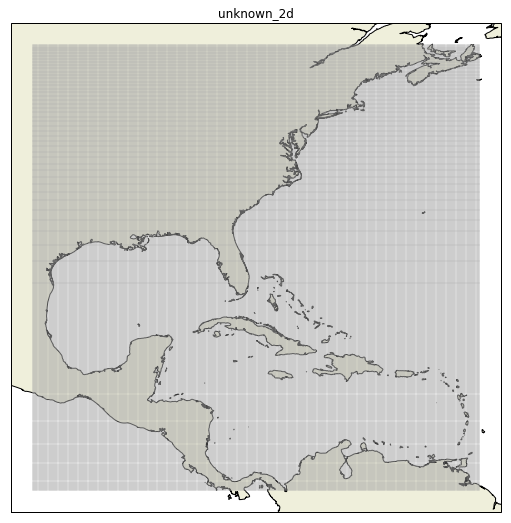

In [4]:
name = 'CNAPS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,NECOFS
resolution,1.83 meters
grid type,ugrid
vertical levels,10
time step,3712 seconds


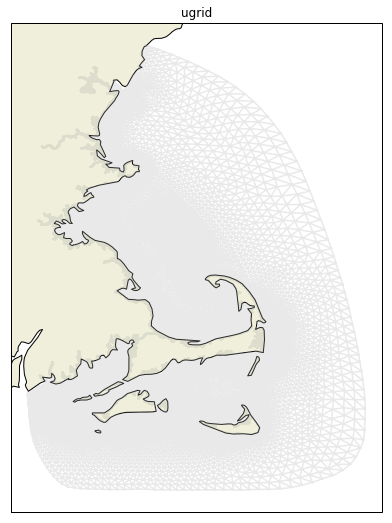

In [5]:
name = 'NECOFS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,ESPRESSO
resolution,0.06 meters
grid type,sgrid
vertical levels,36
time step,86400 seconds


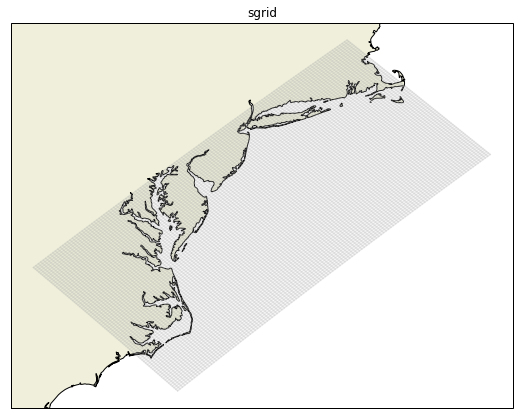

In [6]:
name = 'ESPRESSO'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

```python
# FIXME: WCOFS provides just a few time-steps and only the surface fields.
# That makes it hard to derive the properties we want using the OPeNDAP endpoint.
name = 'WCOFS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])
```

,OSU_ROMS
resolution,0.03 meters
grid type,unknown_2d
vertical levels,40
time step,7200 seconds


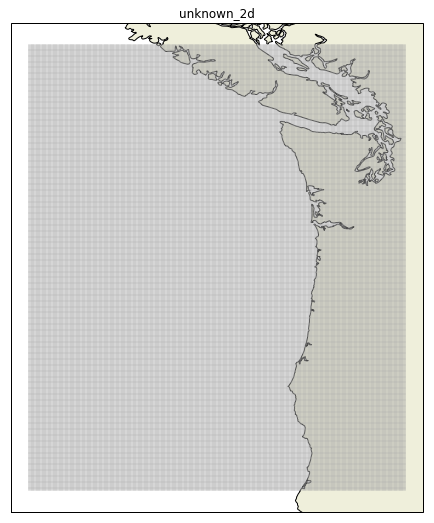

In [7]:
name = 'OSU_ROMS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,NYHOPS
resolution,0.12 meters
grid type,unknown_2d
vertical levels,11
time step,None seconds


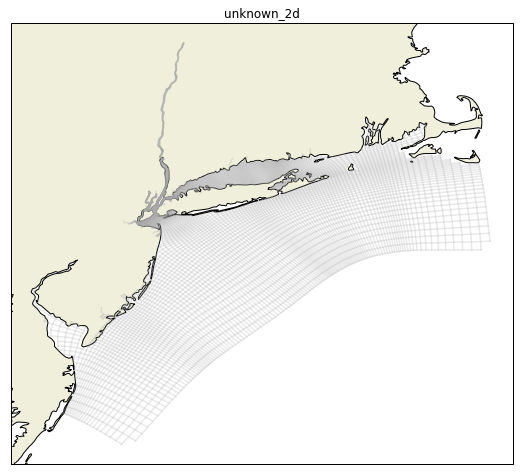

In [8]:
name = 'NYHOPS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,Columbia River
resolution,0.49 meters
grid type,ugrid
vertical levels,None
time step,None seconds


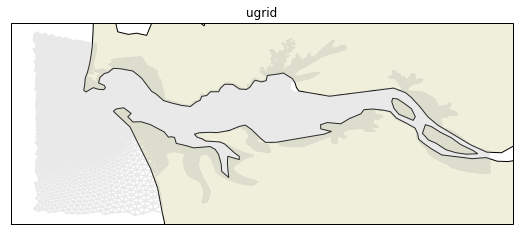

In [9]:
name = 'Columbia River'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,WestCoastUCSC
resolution,0.10 meters
grid type,unknown_2d
vertical levels,11
time step,86400 seconds


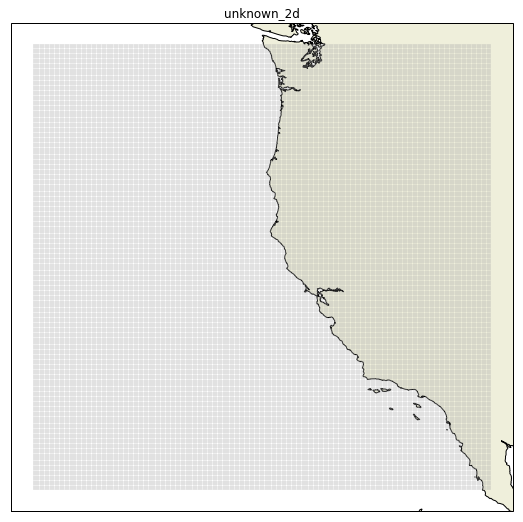

In [10]:
name = 'WestCoastUCSC'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

Most grid are created in such a high resolution that it is quite complicated to create a meaningful visualization even at lower zoom level.
To avoid grid resolution but still allow for a quick domain inspection we can plot only the grid outline.

The next cell will do that and add all the grids above in an interactive map.

In [11]:
%%time

from concurrent.futures import ThreadPoolExecutor

import folium


m = folium.Map()

for name, model in list(models.items()):
    geojson = model['grid'].outline.__geo_interface__

    df = get_stats(model['nc'], name, **model['var'])
    html = to_html(df)

    gj = folium.GeoJson(geojson, name=name)
    gj.add_child(folium.Popup(html))
    gj.add_to(m)

folium.LayerControl().add_to(m)
m.fit_bounds(m.get_bounds());

CPU times: user 5min 1s, sys: 306 ms, total: 5min 1s
Wall time: 5min 2s


In [12]:
def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)

/home/filipe/miniconda3/envs/IOOS/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
